In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from sklearn.metrics import confusion_matrix

import tensorflow as tf

#Bibliotecas de modelos de CNNs
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
#Bibliotecas para treino eficiente da rede
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
#Bibliotecas para montar a rede neural
from tensorflow.keras.layers import Input #Input Layer
from tensorflow.keras.layers import Dense #Dense Layer (Fully connected)
from tensorflow.keras.models import Model #Model Structure
from tensorflow.keras.layers import BatchNormalization #Normalization Layer
from tensorflow.keras.layers import Dropout #Regularization Layer
from tensorflow.keras.layers import Flatten #Reshaping Layer

#Dataset de exemplo do Keras

https://keras.io/api/datasets/

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y = y_train, num_classes = 10)
y_test = tf.keras.utils.to_categorical(y = y_test, num_classes = 10)

#CNN

##Base da rede neural

https://keras.io/api/applications/

https://keras.io/api/applications/resnet/

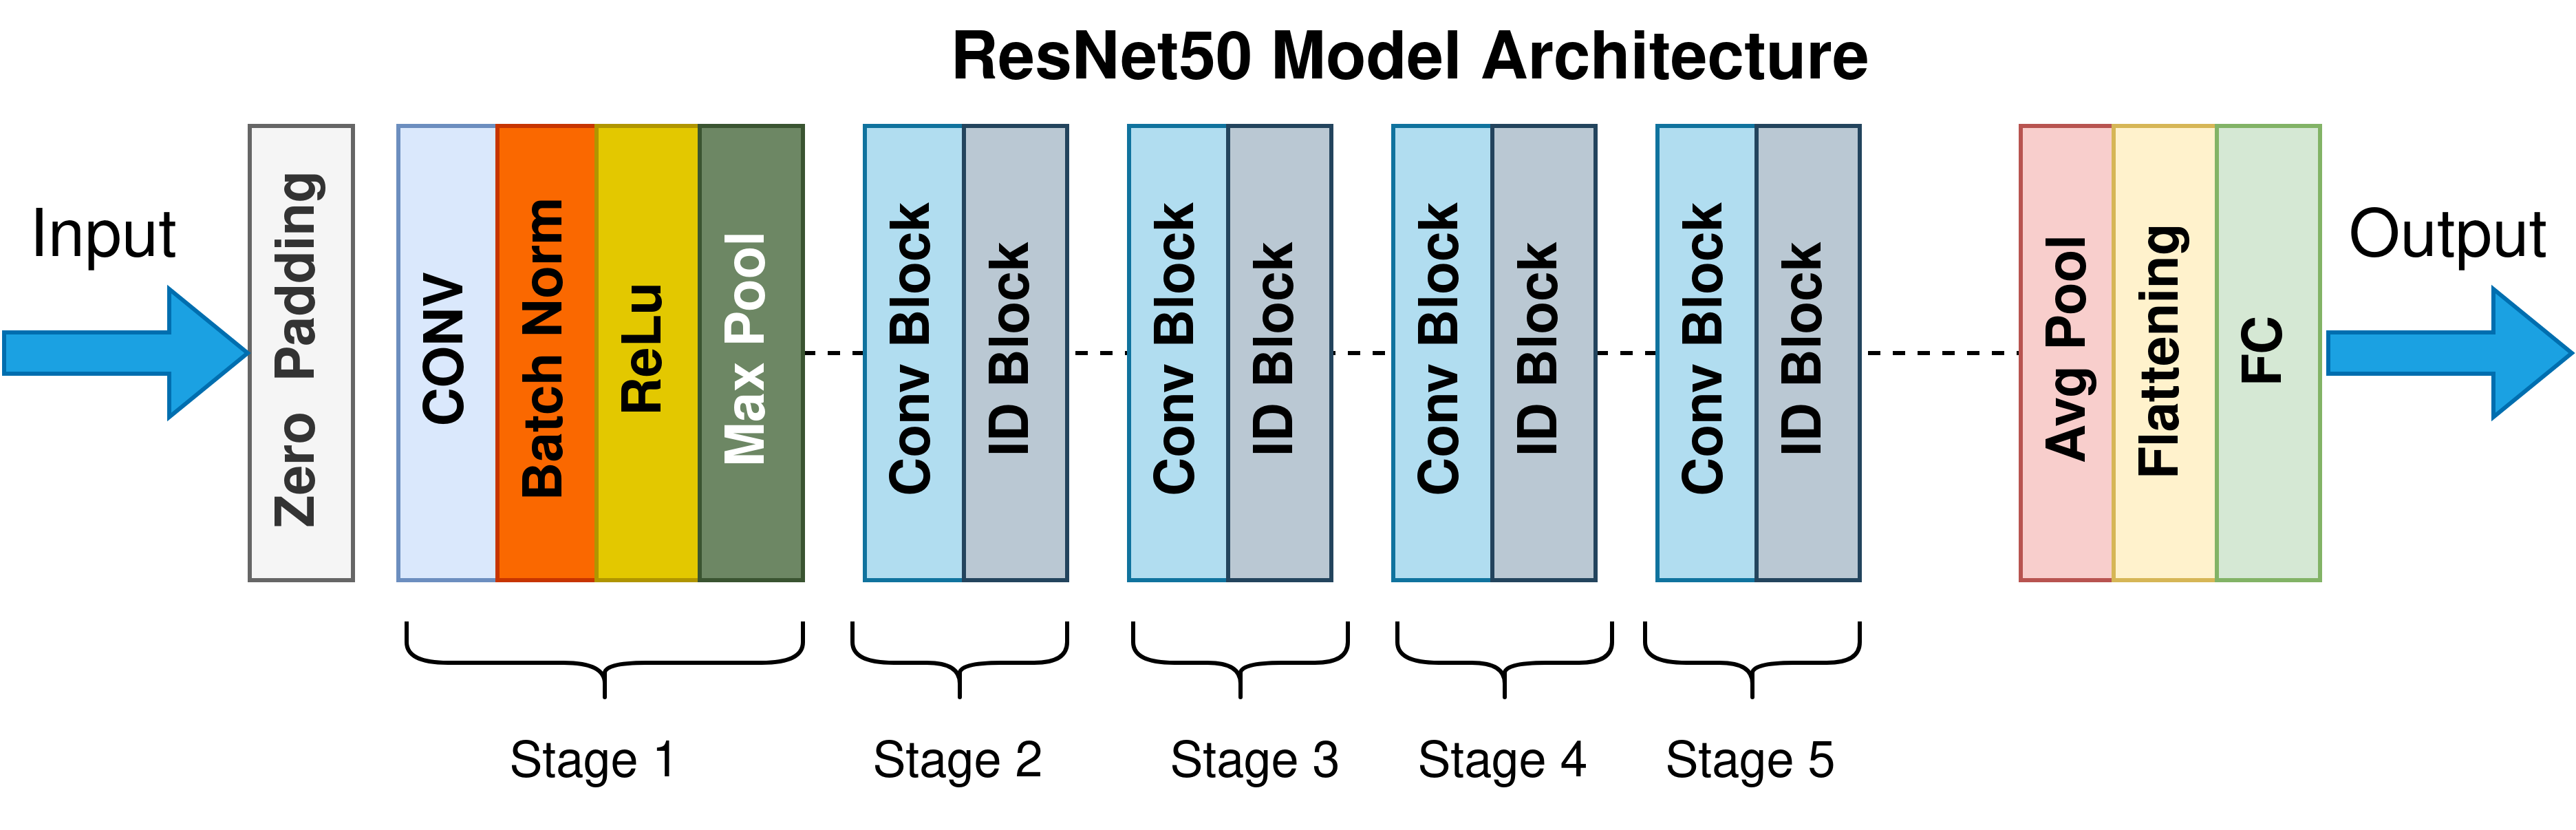

Disponível em:

https://www.google.com/url?sa=i&url=https%3A%2F%2Fcommons.wikimedia.org%2Fwiki%2FFile%3AResNet50.png&psig=AOvVaw3EO0m6e3vHN2n81smFNBCC&ust=1654258943900000&source=images&cd=vfe&ved=2ahUKEwjPt4H34I74AhXBFrkGHZpjDJ0Qr4kDegUIARDAAQ

Acesso em: 01/06/2022

In [17]:
input_shape = (32, 32, 3)
img_input = Input(shape = input_shape)
base_model = ResNet50(include_top = False,
                      input_tensor = img_input,
                      input_shape = input_shape,
                      pooling = "max",
                      weights = 'imagenet')
base_model.trainable = True
#base_model.summary()

##Camada MLP

https://keras.io/api/layers/

In [18]:
x = base_model.output
#Reshaping
x3 = Flatten()(x)
#Core
#Regular densely-connected NN layer.
x3 = Dense(1024, activation = 'relu')(x3)
x3 = Dense(128, activation = 'relu')(x3)
x3 = Dense(16, activation = 'relu')(x3)
#Normalization
#Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
x3 = BatchNormalization()(x3)
#Regularization
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time
x3 = Dropout(0.2)(x3)
#Core
predictions = Dense(10, activation = 'softmax')(x3)

##Montando e compilando o modelo

https://keras.io/api/optimizers/

https://keras.io/api/losses/

https://keras.io/api/metrics/

In [19]:
model = Model(inputs = img_input,
              outputs = predictions)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = [tf.keras.metrics.CategoricalAccuracy(name = "cat_acc"),
                         tf.keras.metrics.AUC(name = 'auc'),
                         tf.keras.metrics.Recall(name = 'recall'),
                         tf.keras.metrics.Precision(name = 'precision')])
#model.summary()

##Treinando o modelo

https://keras.io/api/models/model_training_apis/

https://keras.io/api/callbacks/

In [ ]:
rlrp = ReduceLROnPlateau(patience = 3, verbose = 0)
mc = ModelCheckpoint(filepath = 'bestmodel.h5', verbose = 0, monitor = "cat_acc", mode = "max", save_best_only=True)
hist = model.fit(x = x_train, y = y_train,
                 batch_size = 32,
                 epochs = 10,
                 verbose = 1,
                 validation_data = (x_test, y_test),
                 shuffle = True,
                 callbacks = [rlrp, mc])

Epoch 1/5
1563/1563 [==============================] - 86s 51ms/step - loss: 1.4719 - cat_acc: 0.5255 - auc: 0.8708 - recall: 0.2782 - precision: 0.7906 - val_loss: 0.9452 - val_cat_acc: 0.7179 - val_auc: 0.9530 - val_recall: 0.5472 - val_precision: 0.8645 - lr: 1.0000e-04
Epoch 2/5
1563/1563 [==============================] - 71s 46ms/step - loss: 0.9549 - cat_acc: 0.7204 - auc: 0.9476 - recall: 0.5551 - precision: 0.8440 - val_loss: 0.7299 - val_cat_acc: 0.7740 - val_auc: 0.9701 - val_recall: 0.6805 - val_precision: 0.8582 - lr: 1.0000e-04
Epoch 3/5
1387/1563 [=========================>....] - ETA: 7s - loss: 0.7509 - cat_acc: 0.7836 - auc: 0.9661 - recall: 0.6752 - precision: 0.8679

##Medindo o modelo

In [ ]:
best_model = tf.keras.models.load_model('bestmodel.h5')
preds = best_model.predict(x_test, verbose = 0)
evaluation_model = best_model.evaluate(x = x_test, y = y_test, verbose = 0)
metrics_labels = ['loss', 'cat_acc', 'auc', 'recall', 'precision']
print(tuple(zip(metrics_labels, evaluation_model)))
print(confusion_matrix(y_test, np.argmax(preds, axis = 1)))

##Evolução do treinamento

In [ ]:
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'test')
plt.legend()
plt.show()

##Tópico extra

https://keras.io/guides/transfer_learning/